## Acknowledgements

This work makes use of the **Wearable Device Dataset During Stress and Exercise**, 
created and shared by Proto Bioengineering on Kaggle.　https://www.kaggle.com/datasets/protobioengineering/wearable-device-dataset-during-stress-and-exercise

I would like to sincerely thank the authors for making this high-quality, well-structured 
physiological dataset publicly available.  
Their work enables reproducible research on stress, recovery dynamics, and human-centered 
health analytics, and was essential for this analysis.

In [1]:
# !pip -q install transformers accelerate sentencepiece

import os, glob, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List, Any, Optional

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
plt.rcParams["figure.dpi"] = 120


## 1. Auto-detect dataset path

In [2]:
def find_wearable_base():
    candidates = glob.glob("/kaggle/input/**/Wearable_Dataset", recursive=True)
    candidates = [c for c in candidates if os.path.isdir(c)]
    if not candidates:
        return None
    candidates = sorted(candidates, key=lambda x: len(x), reverse=True)
    return candidates[0]

BASE = find_wearable_base()
print("Auto-found BASE:", BASE)

if BASE is None:
    raise RuntimeError("Wearable_Dataset not found. Kaggle sidebar → Add data → attach the dataset, then rerun.")

AEROBIC_DIR = os.path.join(BASE, "AEROBIC")
print("AEROBIC_DIR:", AEROBIC_DIR, "exists:", os.path.exists(AEROBIC_DIR))
print("Session folders under BASE:", sorted([d for d in os.listdir(BASE) if os.path.isdir(os.path.join(BASE,d))])[:20])

if not os.path.exists(AEROBIC_DIR):
    session_dirs = [d for d in os.listdir(BASE) if os.path.isdir(os.path.join(BASE,d))]
    if not session_dirs:
        raise RuntimeError(f"No session directories found under BASE={BASE}")
    AEROBIC_DIR = os.path.join(BASE, session_dirs[0])
    print("AEROBIC not found; falling back to:", AEROBIC_DIR)

print("Top-level subjects:", sorted(os.listdir(AEROBIC_DIR))[:30])


Auto-found BASE: /kaggle/input/wearable-device-dataset-during-stress-and-exercise/wearable-device-dataset-from-induced-stress-and-structured-exercise-sessions-1.0.1/Wearable_Dataset
AEROBIC_DIR: /kaggle/input/wearable-device-dataset-during-stress-and-exercise/wearable-device-dataset-from-induced-stress-and-structured-exercise-sessions-1.0.1/Wearable_Dataset/AEROBIC exists: True
Session folders under BASE: ['AEROBIC', 'ANAEROBIC', 'STRESS']
Top-level subjects: ['S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', 'S09', 'S10', 'S11_a', 'S11_b', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08', 'f09', 'f10', 'f11', 'f12']


## 2. Empatica CSV readers

In [3]:
def read_empatica_timeseries(csv_path, kind="scalar"):
    """
    Empatica CSV:
    row 0 : start datetime string
    row 1 : sampling rate (Hz)
    row 2+: samples
    """
    raw = pd.read_csv(csv_path, header=None)

    start_time = pd.to_datetime(raw.iloc[0,0])
    fs = float(raw.iloc[1,0])
    data = raw.iloc[2:].copy()

    if kind == "acc":
        data = data.iloc[:, :3].astype(float)
        cols = ["acc_x", "acc_y", "acc_z"]
        values = data.values
    else:
        values = data.iloc[:,0].astype(float).values
        cols = [os.path.splitext(os.path.basename(csv_path))[0].lower()]

    n = len(values)
    times = start_time + pd.to_timedelta(np.arange(n) / fs, unit="s")
    df = pd.DataFrame(values, index=times, columns=cols)
    return df, fs, start_time

def read_tags(csv_path):
    if not os.path.exists(csv_path):
        return pd.DatetimeIndex([])
    raw = pd.read_csv(csv_path, header=None)
    return pd.to_datetime(raw.iloc[:,0])

def read_ibi(csv_path):
    raw = pd.read_csv(csv_path, header=None)
    start_time = pd.to_datetime(raw.iloc[0,0])
    data = raw.iloc[1:].copy()
    data.columns = ["offset_s", "ibi_s"]
    data = data.dropna().astype(float)
    times = start_time + pd.to_timedelta(data["offset_s"], unit="s")
    df = pd.DataFrame({"ibi_s": data["ibi_s"].values}, index=times)
    return df, start_time


## 3. Subject loader

In [4]:
def list_subject_folders(root_dir):
    if root_dir is None or (not os.path.exists(root_dir)):
        return []
    return [d for d in sorted(os.listdir(root_dir)) if os.path.isdir(os.path.join(root_dir, d))]

def load_one_subject_empatica(subj_path):
    paths = {
        "EDA": os.path.join(subj_path, "EDA.csv"),
        "TEMP": os.path.join(subj_path, "TEMP.csv"),
        "BVP": os.path.join(subj_path, "BVP.csv"),
        "ACC": os.path.join(subj_path, "ACC.csv"),
        "HR": os.path.join(subj_path, "HR.csv"),
        "IBI": os.path.join(subj_path, "IBI.csv"),
        "TAGS": os.path.join(subj_path, "tags.csv"),
    }

    eda, fs_eda, _ = read_empatica_timeseries(paths["EDA"], kind="scalar")
    temp, fs_temp, _ = read_empatica_timeseries(paths["TEMP"], kind="scalar")
    bvp, fs_bvp, _ = read_empatica_timeseries(paths["BVP"], kind="scalar")
    acc, fs_acc, _ = read_empatica_timeseries(paths["ACC"], kind="acc")
    hr,  fs_hr,  _ = read_empatica_timeseries(paths["HR"],  kind="scalar")

    ibi, _ = read_ibi(paths["IBI"]) if os.path.exists(paths["IBI"]) else (None, None)
    tags = read_tags(paths["TAGS"])

    ts = eda.join(temp, how="outer").join(bvp, how="outer").join(acc, how="outer").join(hr, how="outer")
    if ibi is not None:
        ts = ts.join(ibi, how="outer")
    ts = ts.sort_index()

    meta = {
        "fs": {"EDA":fs_eda, "TEMP":fs_temp, "BVP":fs_bvp, "ACC":fs_acc, "HR":fs_hr},
        "tags": pd.DatetimeIndex(tags),
        "tag_count": int(len(tags)),
    }
    return ts, meta


## 4. Window features

In [5]:
def featurize_window(df_win: pd.DataFrame) -> dict:
    out = {}
    for c in ["eda", "temp", "hr", "bvp"]:
        if c in df_win.columns:
            x = df_win[c].dropna().astype(float)
            out[f"{c}_mean"] = float(x.mean()) if len(x) else np.nan
            out[f"{c}_std"]  = float(x.std(ddof=0)) if len(x) else np.nan

    if set(["acc_x","acc_y","acc_z"]).issubset(df_win.columns):
        ax = df_win["acc_x"].astype(float)
        ay = df_win["acc_y"].astype(float)
        az = df_win["acc_z"].astype(float)
        mag = np.sqrt(ax*ax + ay*ay + az*az).dropna()
        out["acc_mag_mean"] = float(mag.mean()) if len(mag) else np.nan
        out["acc_mag_std"]  = float(mag.std(ddof=0)) if len(mag) else np.nan

    if "ibi_s" in df_win.columns:
        ibi = df_win["ibi_s"].dropna().astype(float)
        out["ibi_mean"] = float(ibi.mean()) if len(ibi) else np.nan
        out["ibi_std"]  = float(ibi.std(ddof=0)) if len(ibi) else np.nan

    return out

def make_feature_table(ts: pd.DataFrame, entity_id: str, window="1min") -> pd.DataFrame:
    rows = []
    for t, df_win in ts.resample(window):
        feat = featurize_window(df_win)
        feat["entity_id"] = entity_id
        feat["date"] = t
        rows.append(feat)
    return pd.DataFrame(rows).sort_values(["entity_id","date"]).reset_index(drop=True)


## 5. Build multi-subject feature table

In [6]:
MAX_SUBJECTS = 10
WINDOW = "1min"

subjects = list_subject_folders(AEROBIC_DIR)
print("n_subjects:", len(subjects), "example:", subjects[:10])

tags_by_subject = {}
all_feat = []
fail_log = []

for s in subjects[:MAX_SUBJECTS]:
    try:
        subj_path = os.path.join(AEROBIC_DIR, s)
        ts, meta = load_one_subject_empatica(subj_path)
        feat_df = make_feature_table(ts, entity_id=s, window=WINDOW)

        if feat_df is None or len(feat_df) == 0:
            fail_log.append((s, "feat_df empty"))
            continue

        tags_by_subject[s] = meta["tags"]
        all_feat.append(feat_df)

    except Exception as e:
        fail_log.append((s, repr(e)))

print("loaded subjects:", len(all_feat))
print("failures:", len(fail_log))
if fail_log:
    print("first 10 failures:", fail_log[:10])

if len(all_feat) == 0:
    raise RuntimeError("No subjects loaded. Check dataset attachment and folder structure.")

df = pd.concat(all_feat, axis=0, ignore_index=True).copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["entity_id","date"]).reset_index(drop=True)

print("df:", df.shape, "subjects:", df["entity_id"].nunique())
df.head()


n_subjects: 31 example: ['S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', 'S09', 'S10']
loaded subjects: 10
failures: 0
df: (334, 14) subjects: 10


,eda_mean,eda_std,temp_mean,temp_std,hr_mean,hr_std,bvp_mean,bvp_std,acc_mag_mean,acc_mag_std,ibi_mean,ibi_std,entity_id,date
0,0.182448,0.023653,35.826957,0.021955,100.371538,9.113404,0.272221,61.388249,63.154789,2.130853,0.575893,0.017576,S01,2013-03-03 17:43:00
1,0.194539,0.004525,35.766000,0.039758,95.264500,2.133682,-0.120667,21.773051,63.216361,1.470718,0.612868,0.025856,S01,2013-03-03 17:44:00
2,0.207574,0.003845,35.612167,0.049298,96.951000,0.800730,0.032667,21.095649,63.255968,1.541693,0.610322,0.034607,S01,2013-03-03 17:45:00
3,0.217518,0.003061,35.435167,0.052233,98.717333,0.930480,0.048273,24.223764,63.236355,1.628310,0.621264,0.039927,S01,2013-03-03 17:46:00
4,0.223592,0.004880,35.252667,0.062660,98.301667,1.283727,-0.025888,25.235815,63.248627,1.764875,0.591346,0.023614,S01,2013-03-03 17:47:00


## 6. Post-event recovery metrics (tag-aware)

Assumption: **higher is worse**, so recovery after an event corresponds to **decreasing** HR/EDA.
If you want the opposite, set `direction=-1` for that signal.


In [7]:
def _median_ignore_nan(x: pd.Series) -> float:
    x = x.dropna()
    return float(x.median()) if len(x) else np.nan

def _first_time_within(series: pd.Series, target: float, tol: float) -> Optional[pd.Timestamp]:
    if np.isnan(target):
        return None
    ok = (series - target).abs() <= tol
    if ok.any():
        return series.index[ok.argmax()]
    return None

def compute_event_metrics(df_ent: pd.DataFrame, tag_time: pd.Timestamp, signal: str,
                          pre_minutes: int=10, post_minutes: int=20, tol: float=0.30, direction: int=+1) -> Dict[str, Any]:
    df_ent = df_ent.sort_values("date")
    ts = df_ent.set_index("date")[signal].astype(float)
    sd = ts.std(ddof=0)
    z = ts*0.0 if (sd == 0 or np.isnan(sd)) else (ts - ts.mean()) / sd
    z = z.replace([np.inf, -np.inf], np.nan)

    t0 = pd.Timestamp(tag_time)
    pre  = z.loc[(z.index >= t0 - pd.Timedelta(minutes=pre_minutes)) & (z.index < t0)]
    post = z.loc[(z.index >= t0) & (z.index <= t0 + pd.Timedelta(minutes=post_minutes))]

    baseline = _median_ignore_nan(pre)
    if np.isnan(baseline):
        baseline = _median_ignore_nan(post.head(max(3, len(post)//5)))

    if len(post.dropna()) < 5:
        return {"signal": signal, "tag_time": str(t0), "quality": "low",
                "slope": np.nan, "time_to_baseline_min": np.nan, "excess_auc": np.nan,
                "rebound": False, "post_points": int(len(post.dropna()))}

    y = post.dropna()
    mins = (y.index - t0) / pd.Timedelta(minutes=1)
    x = mins.values.astype(float)
    yy = y.values.astype(float)

    x0 = x - x.mean()
    y0 = yy - yy.mean()
    denom = np.sum(x0*x0)
    slope = float(np.sum(x0*y0) / denom) if denom != 0 else np.nan

    t_hit = _first_time_within(y, baseline, tol=tol)
    time_to_base = float(((t_hit - t0) / pd.Timedelta(minutes=1))) if t_hit is not None else np.nan

    excess = (y - baseline) * direction
    excess_pos = excess.clip(lower=0)
    auc = float(np.trapezoid(excess_pos.values, x=(excess_pos.index - t0) / pd.Timedelta(minutes=1))) if len(excess_pos) >= 2 else np.nan

    rebound = False
    if t_hit is not None:
        after = y.loc[y.index > t_hit]
        if len(after):
            rebound = bool(((after - baseline) * direction > tol).any())

    return {"signal": signal, "tag_time": str(t0), "quality": "ok",
            "slope": slope, "time_to_baseline_min": time_to_base, "excess_auc": auc,
            "rebound": rebound, "post_points": int(len(y))}


In [8]:
REC_CFG = {
    "signals": ["hr_mean", "eda_mean"],
    "pre_minutes": 10,
    "post_minutes": 20,
    "tol": 0.30,
    "direction": {"hr_mean": +1, "eda_mean": +1},
    "good_slope": -0.015,
    "bad_slope":  +0.010,
    "slow_time":  12.0,
    "high_auc":   2.5,
    "rebound_rate_high": 0.35,
}
REC_CFG["signals"] = [c for c in REC_CFG["signals"] if c in df.columns]
print("signals used:", REC_CFG["signals"])


signals used: ['hr_mean', 'eda_mean']


In [9]:
def aggregate_events(event_list: List[Dict[str, Any]]) -> Dict[str, Any]:
    per_sig = {}
    for e in event_list:
        per_sig.setdefault(e["signal"], []).append(e)

    agg = {"per_signal": {}, "overall": {}}
    for s, items in per_sig.items():
        slope = np.array([it["slope"] for it in items if not np.isnan(it["slope"])])
        ttb   = np.array([it["time_to_baseline_min"] for it in items if not np.isnan(it["time_to_baseline_min"])])
        auc   = np.array([it["excess_auc"] for it in items if not np.isnan(it["excess_auc"])])
        reb   = np.array([1.0 if it["rebound"] else 0.0 for it in items])

        agg["per_signal"][s] = {
            "n_events": len(items),
            "median_slope": float(np.median(slope)) if len(slope) else np.nan,
            "median_time_to_baseline_min": float(np.median(ttb)) if len(ttb) else np.nan,
            "median_excess_auc": float(np.median(auc)) if len(auc) else np.nan,
            "rebound_rate": float(np.mean(reb)) if len(reb) else np.nan,
        }

    med_slopes = [v["median_slope"] for v in agg["per_signal"].values() if not np.isnan(v["median_slope"])]
    med_ttb    = [v["median_time_to_baseline_min"] for v in agg["per_signal"].values() if not np.isnan(v["median_time_to_baseline_min"])]
    med_auc    = [v["median_excess_auc"] for v in agg["per_signal"].values() if not np.isnan(v["median_excess_auc"])]
    reb_rates  = [v["rebound_rate"] for v in agg["per_signal"].values() if not np.isnan(v["rebound_rate"])]

    agg["overall"] = {
        "median_slope": float(np.mean(med_slopes)) if len(med_slopes) else np.nan,
        "median_time_to_baseline_min": float(np.mean(med_ttb)) if len(med_ttb) else np.nan,
        "median_excess_auc": float(np.mean(med_auc)) if len(med_auc) else np.nan,
        "mean_rebound_rate": float(np.mean(reb_rates)) if len(reb_rates) else np.nan,
    }
    return agg

def classify_recovery(agg: Dict[str, Any]) -> str:
    o = agg["overall"]
    slope = o["median_slope"]
    ttb   = o["median_time_to_baseline_min"]
    auc   = o["median_excess_auc"]
    rr    = o["mean_rebound_rate"]

    if np.isnan(slope) and np.isnan(ttb) and np.isnan(auc):
        return "unknown"
    if (not np.isnan(slope) and slope >= REC_CFG["bad_slope"]) or (not np.isnan(rr) and rr >= REC_CFG["rebound_rate_high"]):
        return "worsening"
    if (not np.isnan(slope) and slope <= REC_CFG["good_slope"]) and (np.isnan(ttb) or ttb <= REC_CFG["slow_time"]) and (np.isnan(auc) or auc <= REC_CFG["high_auc"]):
        return "improving"
    return "plateau"

def build_event_metrics_for_subject(df_ent: pd.DataFrame, tags: pd.DatetimeIndex) -> List[Dict[str, Any]]:
    if tags is None or len(tags) == 0:
        return []
    tmin, tmax = df_ent["date"].min(), df_ent["date"].max()
    valid = [t for t in tags if (t >= tmin) and (t <= tmax)]
    out = []
    for t in valid:
        for sig in REC_CFG["signals"]:
            out.append(compute_event_metrics(
                df_ent=df_ent,
                tag_time=t,
                signal=sig,
                pre_minutes=REC_CFG["pre_minutes"],
                post_minutes=REC_CFG["post_minutes"],
                tol=REC_CFG["tol"],
                direction=REC_CFG["direction"].get(sig, +1),
            ))
    return out

def build_recovery_flags(agg: Dict[str, Any]) -> List[Dict[str, Any]]:
    flags = []
    o = agg["overall"]
    slope = o["median_slope"]
    ttb   = o["median_time_to_baseline_min"]
    auc   = o["median_excess_auc"]
    rr    = o["mean_rebound_rate"]

    if not np.isnan(ttb) and ttb > REC_CFG["slow_time"]:
        flags.append({"flag": "slow_recovery", "evidence": f"median time_to_baseline={ttb:.1f} min (> {REC_CFG['slow_time']})"})
    if not np.isnan(auc) and auc > REC_CFG["high_auc"]:
        flags.append({"flag": "high_recovery_burden", "evidence": f"median excess AUC={auc:.2f} (> {REC_CFG['high_auc']})"})
    if not np.isnan(slope) and slope >= REC_CFG["bad_slope"]:
        flags.append({"flag": "non_recovering_trend", "evidence": f"median post-event slope={slope:.4f} z/min (>= {REC_CFG['bad_slope']})"})
    if not np.isnan(rr) and rr >= REC_CFG["rebound_rate_high"]:
        flags.append({"flag": "frequent_rebound", "evidence": f"mean rebound rate={rr:.2f} (>= {REC_CFG['rebound_rate_high']})"})
    return flags

def uncertainty_from_events(event_metrics: List[Dict[str, Any]]) -> Dict[str, Any]:
    if len(event_metrics) == 0:
        return {"level": "high", "reasons": ["no valid tags/events found in the time range"]}
    reasons = []
    q = [1 if e.get("quality") == "ok" else 0 for e in event_metrics]
    ok_rate = float(np.mean(q)) if len(q) else 0.0
    if ok_rate < 0.6:
        reasons.append(f"many low-quality event windows (ok_rate={ok_rate:.2f})")
    small = [1 for e in event_metrics if e.get("post_points", 0) < 8]
    if len(small) / max(1, len(event_metrics)) > 0.25:
        reasons.append("insufficient post-event samples in many windows")
    level = "high" if len(reasons) >= 2 else ("medium" if len(reasons) == 1 else "low")
    return {"level": level, "reasons": reasons}

def summarize_entity_tag_recovery(df_ent: pd.DataFrame, tags: pd.DatetimeIndex) -> Dict[str, Any]:
    entity_id = str(df_ent["entity_id"].iloc[0])
    events = build_event_metrics_for_subject(df_ent, tags)
    agg = aggregate_events(events)
    trend = classify_recovery(agg)
    flags = build_recovery_flags(agg)
    unc = uncertainty_from_events(events)

    return {
        "entity_id": entity_id,
        "trend": trend,
        "signals_used": REC_CFG["signals"],
        "overall": agg["overall"],
        "per_signal": agg["per_signal"],
        "risk_flags": flags,
        "uncertainty": unc,
        "tag_count": int(len(tags)) if tags is not None else 0,
    }


## 7. Summaries + demo visualization

In [10]:
summaries = []
for eid, g in df.groupby("entity_id"):
    tags = tags_by_subject.get(eid, pd.DatetimeIndex([]))
    summaries.append(summarize_entity_tag_recovery(g.sort_values("date"), tags))

print("Summaries:", len(summaries))
pd.DataFrame([{
    "entity_id": s["entity_id"],
    "trend": s["trend"],
    "tag_count": s["tag_count"],
    "flags": len(s["risk_flags"]),
    "uncertainty": s["uncertainty"]["level"]
} for s in summaries]).head(10)


/tmp/ipykernel_17/2358975687.py:49: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = float(np.trapz(excess_pos.values, x=(excess_pos.index - t0) / pd.Timedelta(minutes=1))) if len(excess_pos) >= 2 else np.nan
/tmp/ipykernel_17/2358975687.py:49: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = float(np.trapz(excess_pos.values, x=(excess_pos.index - t0) / pd.Timedelta(minutes=1))) if len(excess_pos) >= 2 else np.nan
/tmp/ipykernel_17/2358975687.py:49: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = float(np.trapz(excess_pos.values, x=(excess_pos.index - t0) / pd.Timedelta(minutes=1))) if len(excess_pos) >= 2 else np.nan
/tmp/ipykernel_17/2358975687.py:49: DeprecationWarning: `trapz` is deprecated. Use `trap

Summaries: 10


/tmp/ipykernel_17/2358975687.py:49: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = float(np.trapz(excess_pos.values, x=(excess_pos.index - t0) / pd.Timedelta(minutes=1))) if len(excess_pos) >= 2 else np.nan
/tmp/ipykernel_17/2358975687.py:49: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = float(np.trapz(excess_pos.values, x=(excess_pos.index - t0) / pd.Timedelta(minutes=1))) if len(excess_pos) >= 2 else np.nan
/tmp/ipykernel_17/2358975687.py:49: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = float(np.trapz(excess_pos.values, x=(excess_pos.index - t0) / pd.Timedelta(minutes=1))) if len(excess_pos) >= 2 else np.nan
/tmp/ipykernel_17/2358975687.py:49: DeprecationWarning: `trapz` is deprecated. Use `trap

,entity_id,trend,tag_count,flags,uncertainty
0,S01,worsening,12,3,low
1,S02,plateau,12,1,low
2,S03,plateau,7,1,medium
3,S04,worsening,12,2,low
4,S05,worsening,12,2,low
5,S06,worsening,12,3,low
6,S07,worsening,9,2,low
7,S08,worsening,12,3,low
8,S09,worsening,12,3,low
9,S10,plateau,12,1,low


In [11]:
def pick_demo_cases_by_trend(summaries, k=3):
    by = {}
    for s in summaries:
        by.setdefault(s["trend"], []).append(s)
    demo = []
    for t in ["improving", "plateau", "worsening"]:
        if t in by and len(by[t]):
            demo.append(by[t][0])
    rest = [s for s in summaries if s not in demo]
    demo += rest[:max(0, k-len(demo))]
    return demo[:k]

demo = pick_demo_cases_by_trend(summaries, k=3)
print("Demo:", [(d["entity_id"], d["trend"], d["tag_count"]) for d in demo])


Demo: [('S02', 'plateau', 12), ('S01', 'worsening', 12), ('S03', 'plateau', 7)]


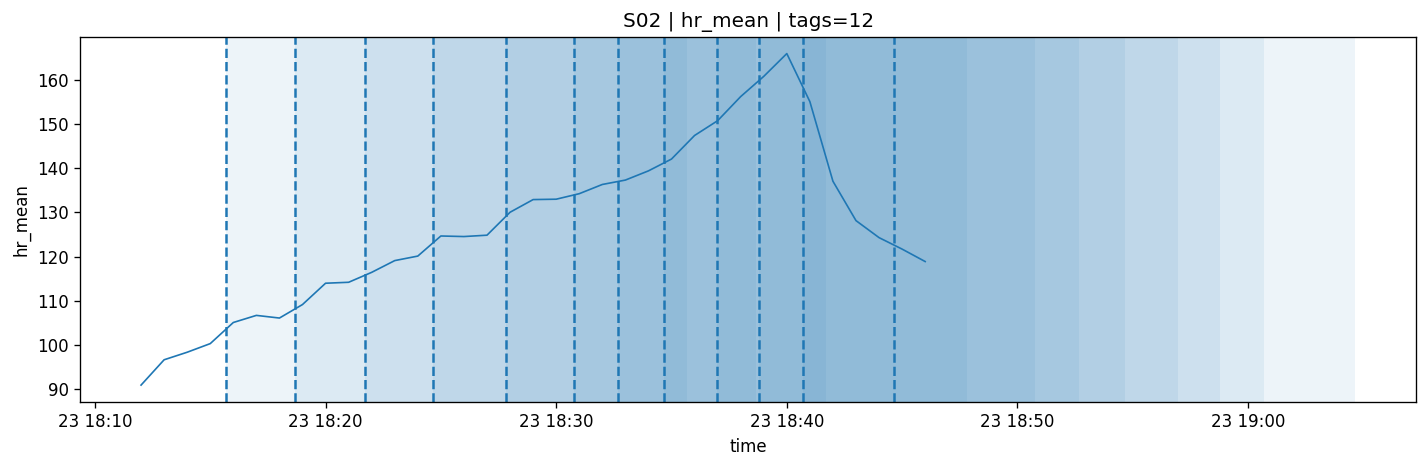

SUMMARY (truncated): {"entity_id": "S02", "trend": "plateau", "signals_used": ["hr_mean", "eda_mean"], "overall": {"median_slope": -0.017447845874443108, "median_time_to_baseline_min": 7.012499999999999, "median_excess_auc": 13.097320482437581, "mean_rebound_rate": 0.08333333333333333}, "per_signal": {"hr_mean": {"n_events": 12, "median_slope": -0.04828495971453323, "m ...
------------------------------------------------------------------------------------------


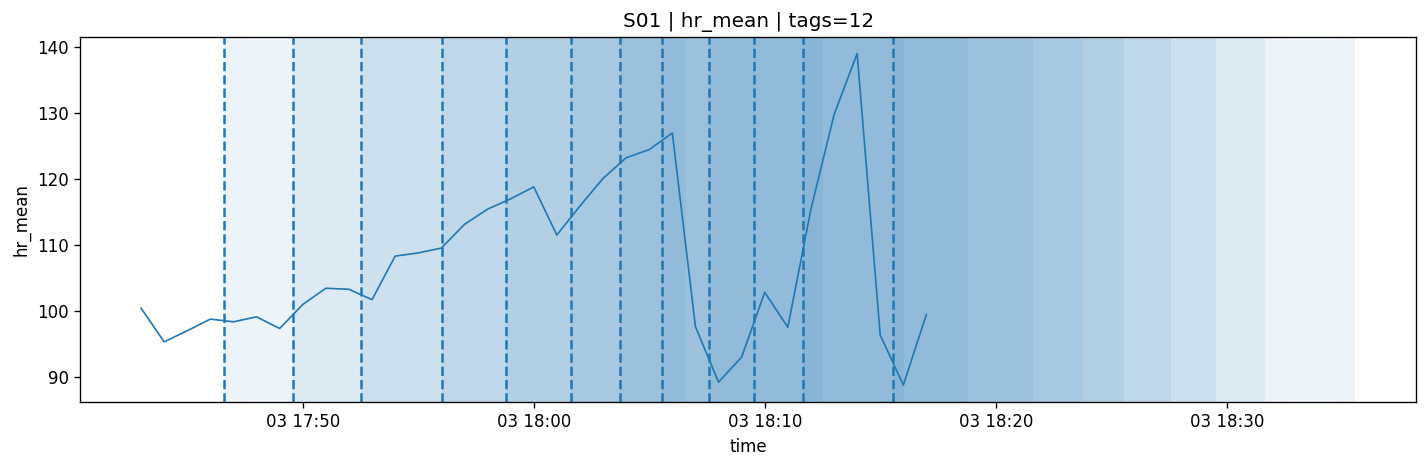

SUMMARY (truncated): {"entity_id": "S01", "trend": "worsening", "signals_used": ["hr_mean", "eda_mean"], "overall": {"median_slope": 0.037774477089395374, "median_time_to_baseline_min": 2.4083333333333337, "median_excess_auc": 14.418982198922487, "mean_rebound_rate": 0.6666666666666667}, "per_signal": {"hr_mean": {"n_events": 12, "median_slope": -0.05266861117283807, " ...
------------------------------------------------------------------------------------------


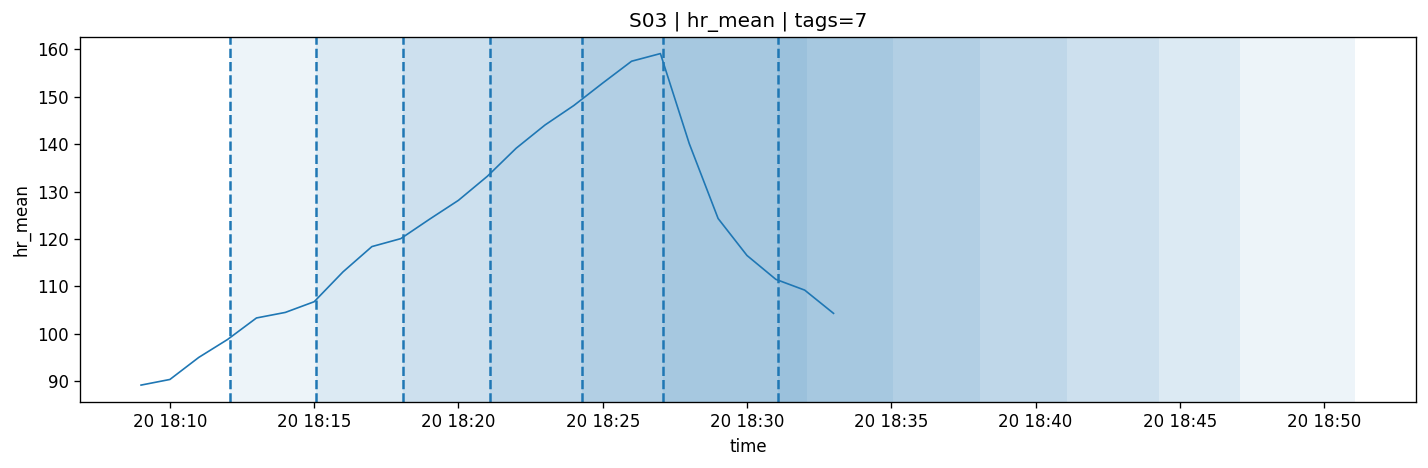

SUMMARY (truncated): {"entity_id": "S03", "trend": "plateau", "signals_used": ["hr_mean", "eda_mean"], "overall": {"median_slope": -0.0425541389900863, "median_time_to_baseline_min": 4.9125000000000005, "median_excess_auc": 20.337705234819538, "mean_rebound_rate": 0.14285714285714285}, "per_signal": {"hr_mean": {"n_events": 7, "median_slope": -0.15242310667161707, "med ...
------------------------------------------------------------------------------------------


In [12]:
def plot_subject_with_tags(df_ent: pd.DataFrame, tags: pd.DatetimeIndex, signal: str):
    df_ent = df_ent.sort_values("date")
    plt.figure(figsize=(12,4))
    plt.plot(df_ent["date"], df_ent[signal], linewidth=1)
    plt.title(f"{df_ent['entity_id'].iloc[0]} | {signal} | tags={len(tags)}")
    plt.xlabel("time"); plt.ylabel(signal)
    for t in tags[:20]:
        plt.axvline(t, linestyle="--")
        plt.axvspan(t, t + pd.Timedelta(minutes=REC_CFG["post_minutes"]), alpha=0.08)
    plt.tight_layout(); plt.show()

for d in demo:
    eid = d["entity_id"]
    g = df[df["entity_id"] == eid]
    tags = tags_by_subject.get(eid, pd.DatetimeIndex([]))
    sig = "hr_mean" if "hr_mean" in g.columns else (REC_CFG["signals"][0] if REC_CFG["signals"] else None)
    if sig is None:
        print("No usable signals found in df.")
        break
    plot_subject_with_tags(g, tags, sig)
    print("SUMMARY (truncated):", json.dumps(d, ensure_ascii=False)[:350], "...")
    print("-"*90)


## 8. Compact JSON for MedGemma + safe stub

In [13]:
def compact_for_llm(summary: Dict[str, Any]) -> Dict[str, Any]:
    return {
        "entity_id": summary["entity_id"],
        "trend": summary["trend"],
        "signals_used": summary["signals_used"],
        "overall": summary["overall"],
        "risk_flags": summary["risk_flags"],
        "uncertainty": summary["uncertainty"],
        "tag_count": summary["tag_count"],
    }

SYSTEM_PROMPT = (
    "You are a clinical documentation assistant.\n"
    "Do NOT diagnose or prescribe treatments.\n"
    "Use the provided structured evidence to write a concise clinical-style note.\n"
    "Be uncertainty-aware and avoid overconfident claims.\n"
)

USER_TEMPLATE = (
    "Patient context (synthetic): {patient_context}\n\n"
    "Structured recovery summary (JSON):\n{summary_json}\n\n"
    "Write output strictly in this format:\n\n"
    "1) Clinical summary (max 5 bullet points)\n"
    "2) Risk level: low/medium/high + rationale (1-2 sentences)\n"
    "3) Questions to ask (max 5 bullets)\n"
    "4) Suggested next step (non-diagnostic, 1-2 bullets)\n"
    "5) Safety note / when to escalate (1-2 bullets)\n"
)

def build_patient_context(entity_id: str) -> str:
    return f"Entity {entity_id}: synthetic wearable monitoring; post-event recovery assessment from HR/EDA."

def llm_stub(prompt_user: str) -> str:
    return (
        "1) Clinical summary\n"
        "- Post-event recovery pattern was summarized from quantitative trajectory metrics.\n"
        "- Evidence suggests improving/plateau/worsening dynamics after tagged events.\n"
        "- Risk flags were generated from recovery burden and rebound frequency.\n"
        "- Uncertainty is explicitly surfaced.\n\n"
        "2) Risk level: medium — rationale: recovery burden/flags present; uncertainty prevents high-confidence escalation.\n\n"
        "3) Questions to ask\n"
        "- Any new or worsening red-flag symptoms?\n"
        "- Any medication changes or missed doses?\n"
        "- Any recent infection exposure or poor sleep?\n"
        "- Functional ability today vs baseline?\n"
        "- Any triggers after the event (activity, dehydration, stressors)?\n\n"
        "4) Suggested next step\n"
        "- Repeat structured check-in over 24–48 hours; consider clinician review if worsening persists.\n\n"
        "5) Safety note / when to escalate\n"
        "- If severe or rapidly worsening symptoms occur, seek urgent medical evaluation immediately.\n"
    )

def generate_clinical_note(summary: Dict[str, Any]) -> str:
    compact = compact_for_llm(summary)
    summary_json = json.dumps(compact, ensure_ascii=False, indent=2)
    user_prompt = USER_TEMPLATE.format(
        patient_context=build_patient_context(compact["entity_id"]),
        summary_json=summary_json
    )
    # Replace stub with real MedGemma inference when available.
    return llm_stub(user_prompt)

if demo:
    print("Example compact JSON:")
    print(json.dumps(compact_for_llm(demo[0]), ensure_ascii=False, indent=2)[:1200])
    print("\nExample note:")
    print(generate_clinical_note(demo[0]))


Example compact JSON:
{
  "entity_id": "S02",
  "trend": "plateau",
  "signals_used": [
    "hr_mean",
    "eda_mean"
  ],
  "overall": {
    "median_slope": -0.017447845874443108,
    "median_time_to_baseline_min": 7.012499999999999,
    "median_excess_auc": 13.097320482437581,
    "mean_rebound_rate": 0.08333333333333333
  },
  "risk_flags": [
    {
      "flag": "high_recovery_burden",
      "evidence": "median excess AUC=13.10 (> 2.5)"
    }
  ],
  "uncertainty": {
    "level": "low",
    "reasons": []
  },
  "tag_count": 12
}

Example note:
1) Clinical summary
- Post-event recovery pattern was summarized from quantitative trajectory metrics.
- Evidence suggests improving/plateau/worsening dynamics after tagged events.
- Risk flags were generated from recovery burden and rebound frequency.
- Uncertainty is explicitly surfaced.

2) Risk level: medium — rationale: recovery burden/flags present; uncertainty prevents high-confidence escalation.

3) Questions to ask
- Any new or worseni